In [83]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.function_base import average, median
import soundfile as sf
from scipy import signal
from scipy.io import wavfile

# Input file
INPUT_FILE = "../audio/xdousa00.wav"

# Frames
FRAME_SIZE = 1024
FRAME_OVERLAP = 512

# Filter params
PASS_LOSS = 3
BLOCK_ATT = 45
BAND_STOP_WIDTH = 30
BAND_DESCEND_WIDTH = 50

frame_shift = FRAME_SIZE - FRAME_OVERLAP

length: 14132 with sample rate 16000Hz (0.88325s)
Stats:
Max: 0.083709716796875, Min: -0.050750732421875, Avg: -1.1360952343307741e-05, Mean: -1.1360952343307741e-05, Med: -9.1552734375e-05


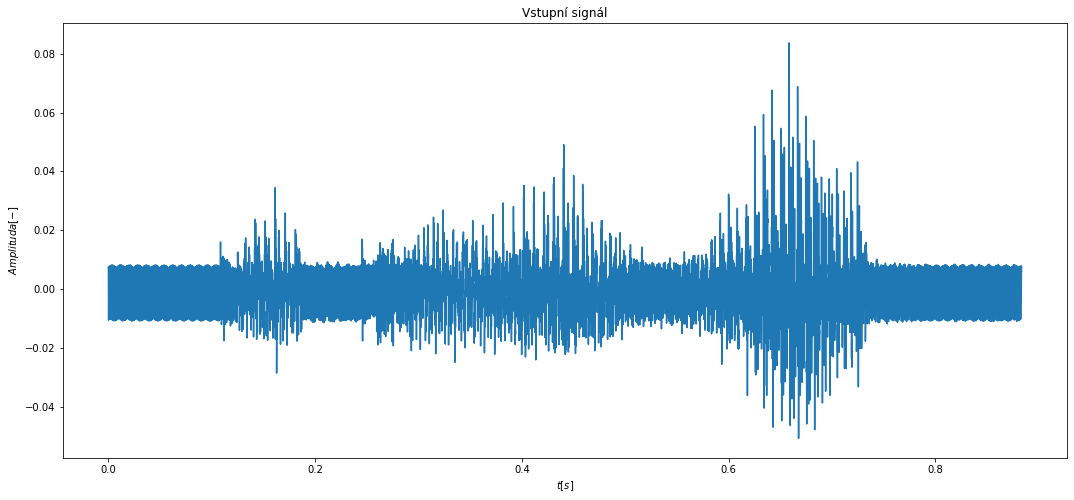

In [84]:
samples_orig, sample_freq = sf.read(INPUT_FILE)
orig_length_in_secs = samples_orig.size / sample_freq

print(f"length: {samples_orig.size} with sample rate {sample_freq}Hz ({orig_length_in_secs}s)")

print(f"Stats:\nMax: {max(samples_orig)}, Min: {min(samples_orig)}, Avg: {average(samples_orig)}, Mean: {np.mean(samples_orig)}, Med: {median(samples_orig)}")

time_to_index_coef = samples_orig.size / orig_length_in_secs

# Show input signal
plt.figure(figsize=(18,8))
plt.title("Vstupní signál")
plt.plot(np.arange(samples_orig.size) / sample_freq, samples_orig)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Amplituda[-]$')
plt.show()

In [85]:
def normalization(samples):
    # Centering
    samples_normal = samples - np.mean(samples)
    max_abs_val = max(abs(samples_normal))

    # Normalization
    samples_normal /= max_abs_val
    return samples_normal

Normalization

[ 0.0883483   0.07704834 -0.0169965  ...  0.03184849  0.09381602
  0.07012256]
Stats:
Max: 1.0, Min: -0.606052535796524, Avg: 1.5122978505543633e-18, Mean: 1.5122978505543633e-18, Med: -0.0009578445976520053


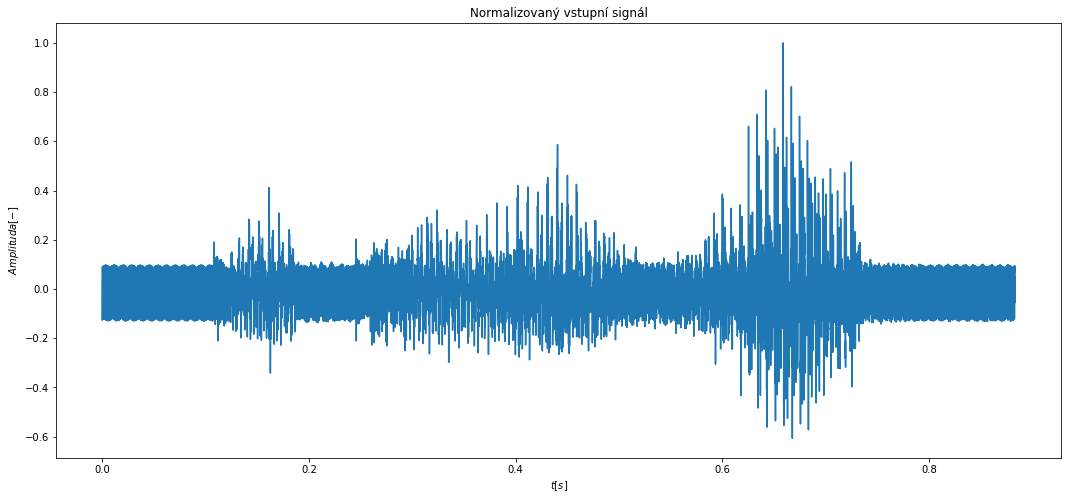

In [86]:
samples_normal = normalization(samples_orig)
print(samples_normal)

print(f"Stats:\nMax: {max(samples_normal)}, Min: {min(samples_normal)}, Avg: {average(samples_normal)}, Mean: {np.mean(samples_normal)}, Med: {median(samples_normal)}")

# Show normalized and centered signal
plt.figure(figsize=(18,8))
plt.title("Normalizovaný vstupní signál")
plt.plot(np.arange(samples_orig.size) / sample_freq, samples_normal)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Amplituda[-]$')
plt.show()

Frames

In [87]:
number_of_frames = samples_normal.size // frame_shift
frames = [samples_normal[idx * frame_shift : FRAME_SIZE + idx * frame_shift] for idx in range(number_of_frames)]

# Pad last frame with zeroes
frames[len(frames) - 1] = np.pad(frames[len(frames) - 1], (0, FRAME_SIZE - frames[len(frames) - 1].shape[0]), "constant")

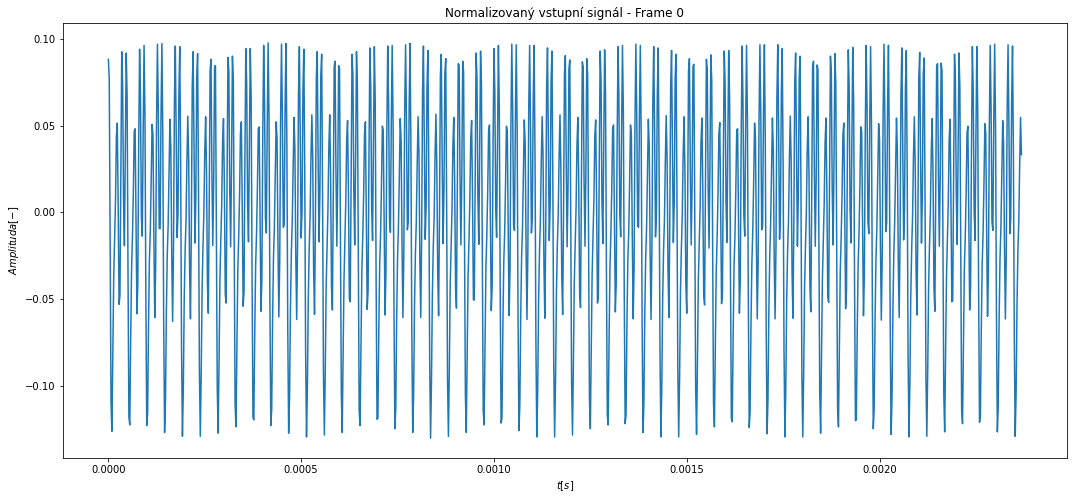

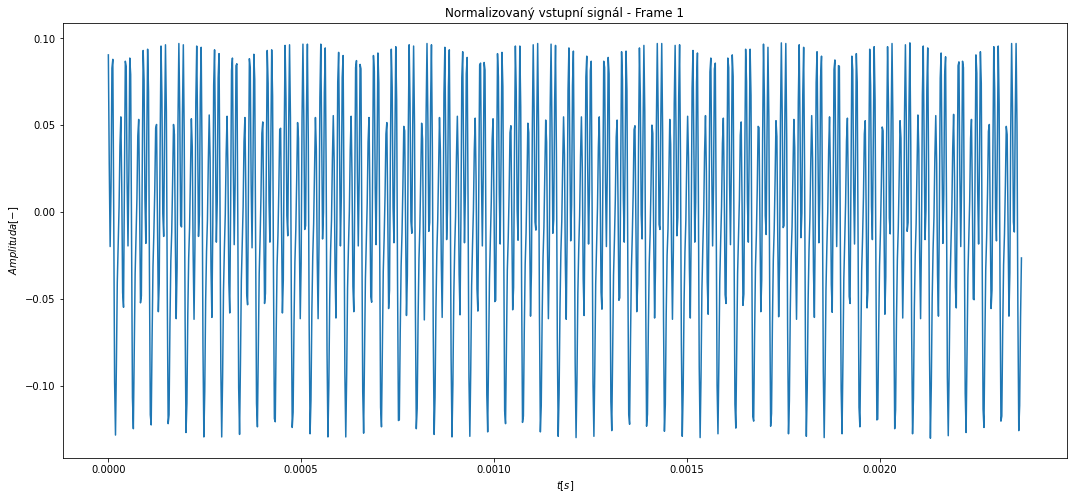

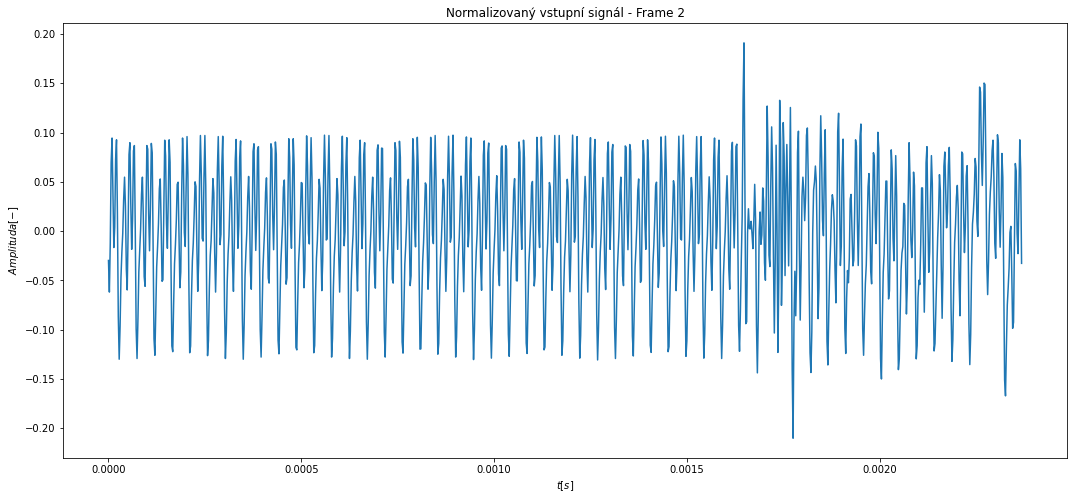

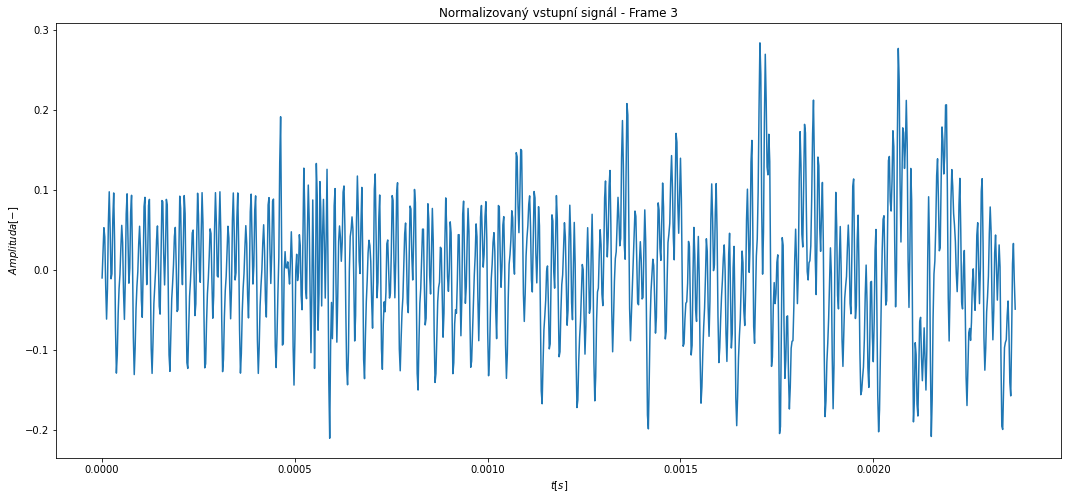

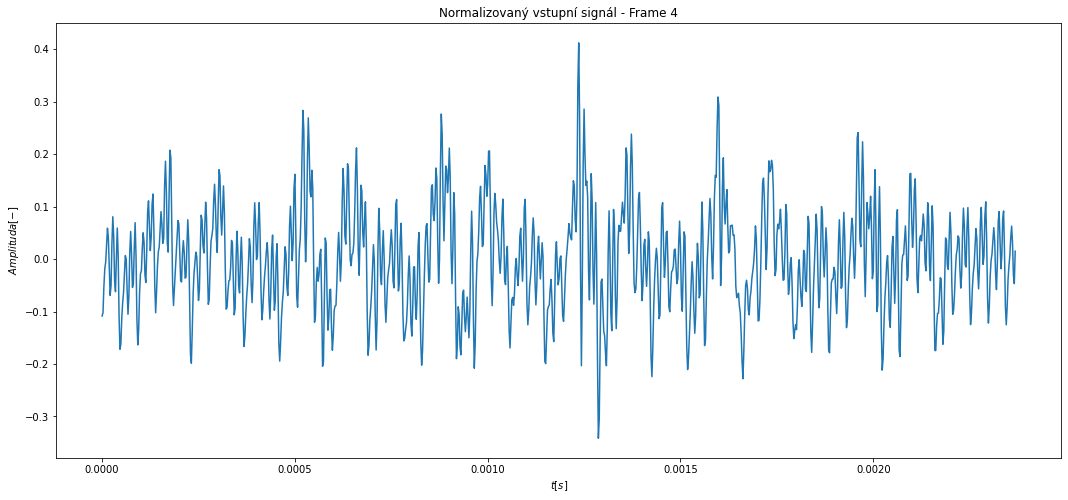

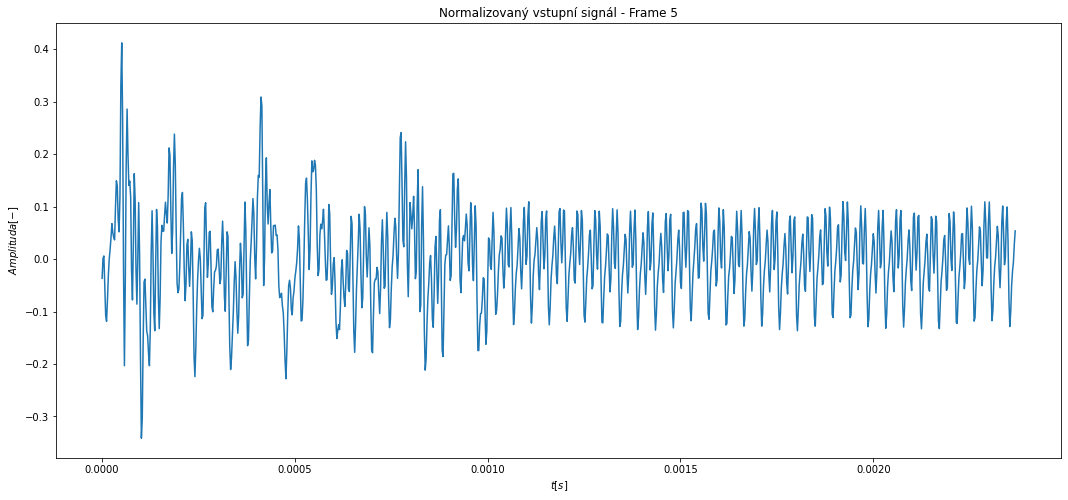

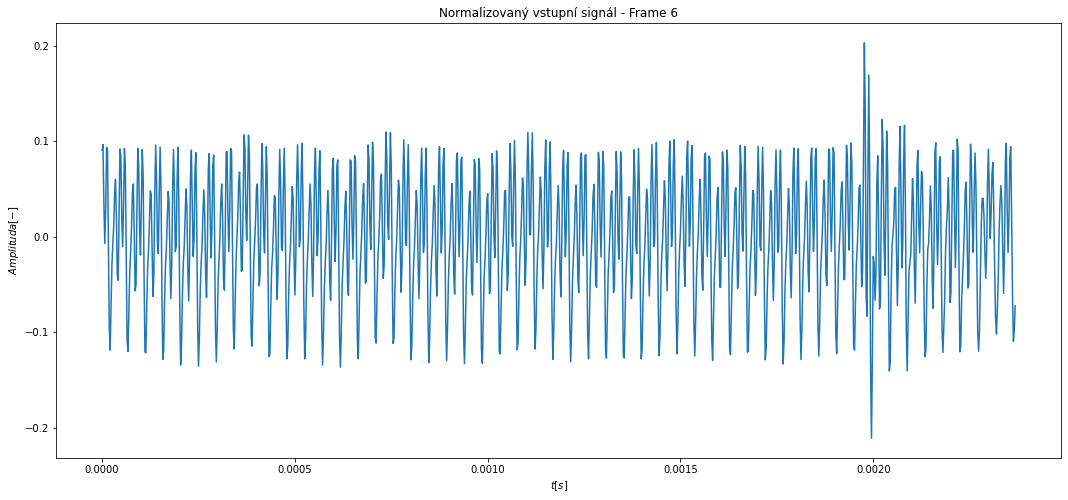

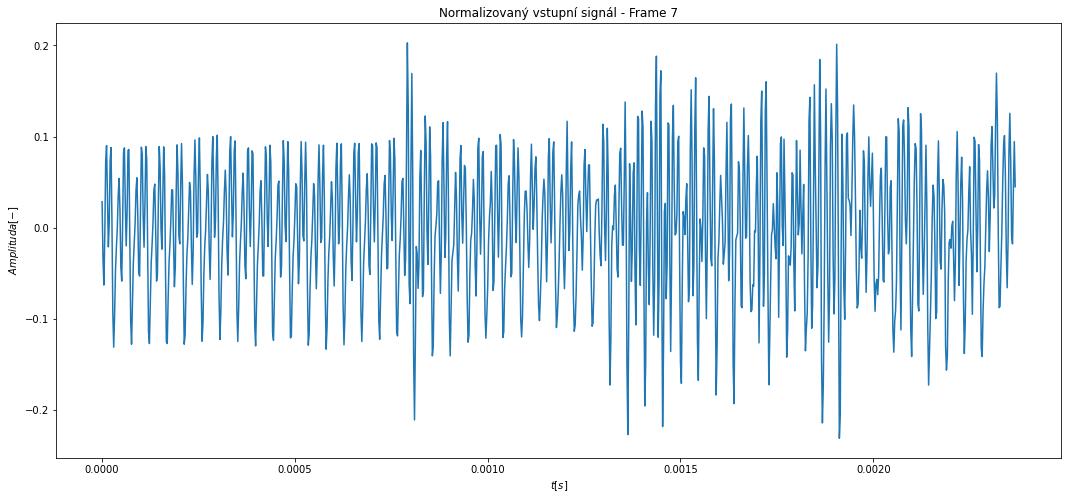

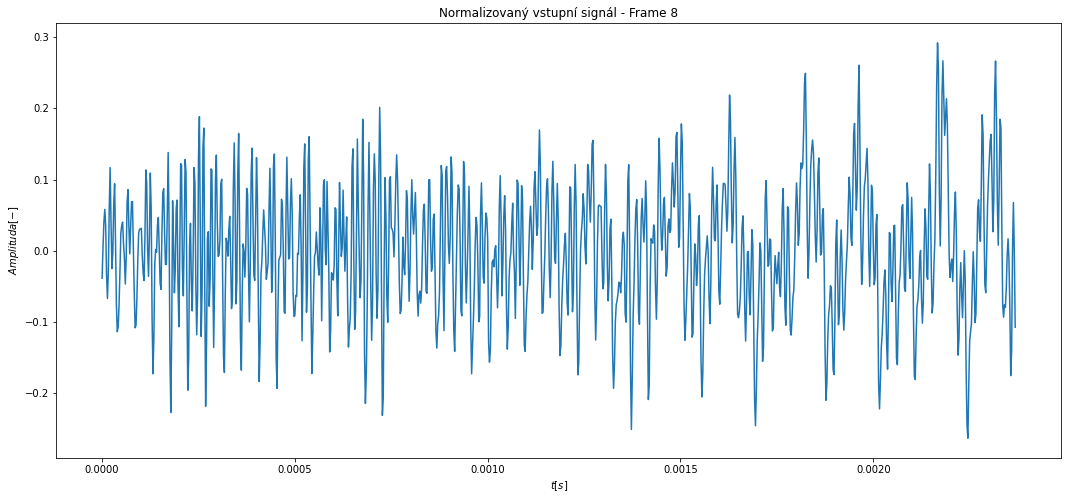

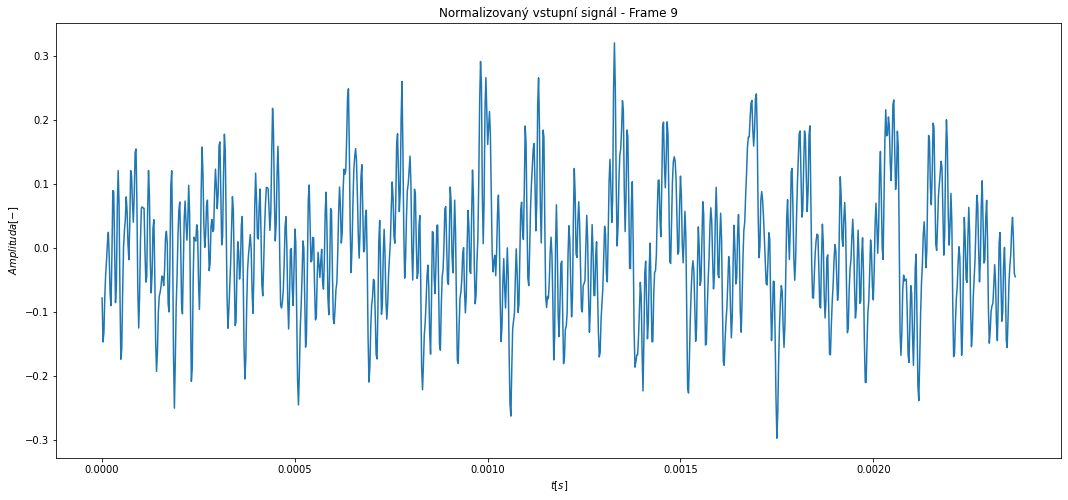

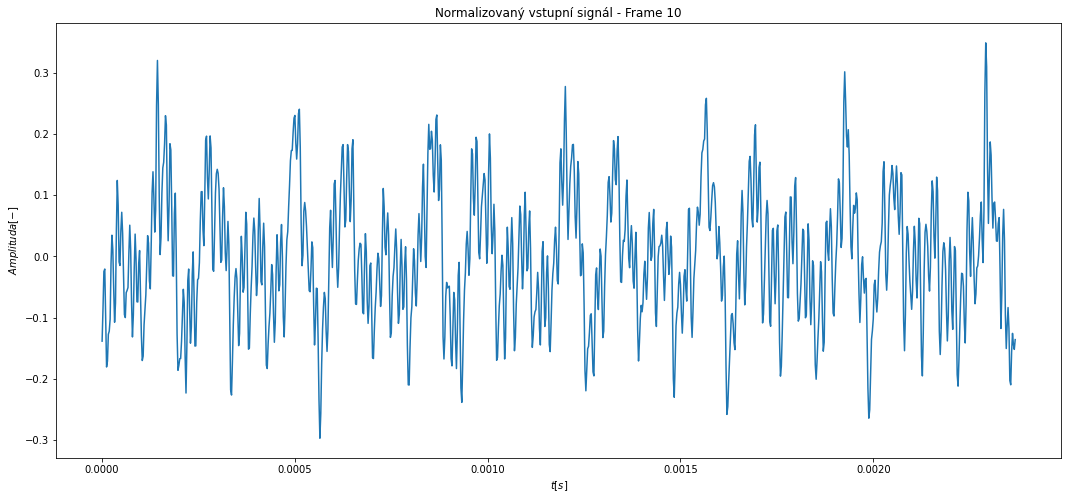

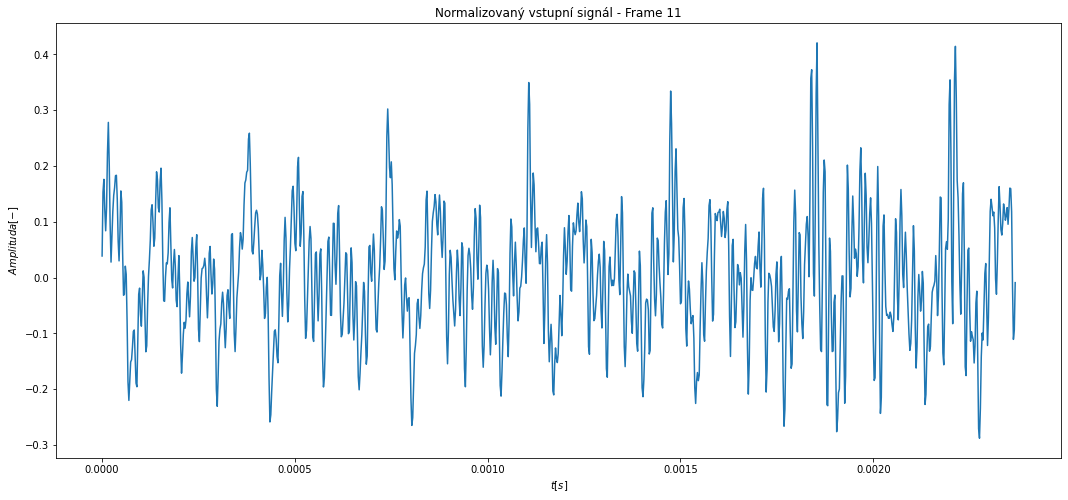

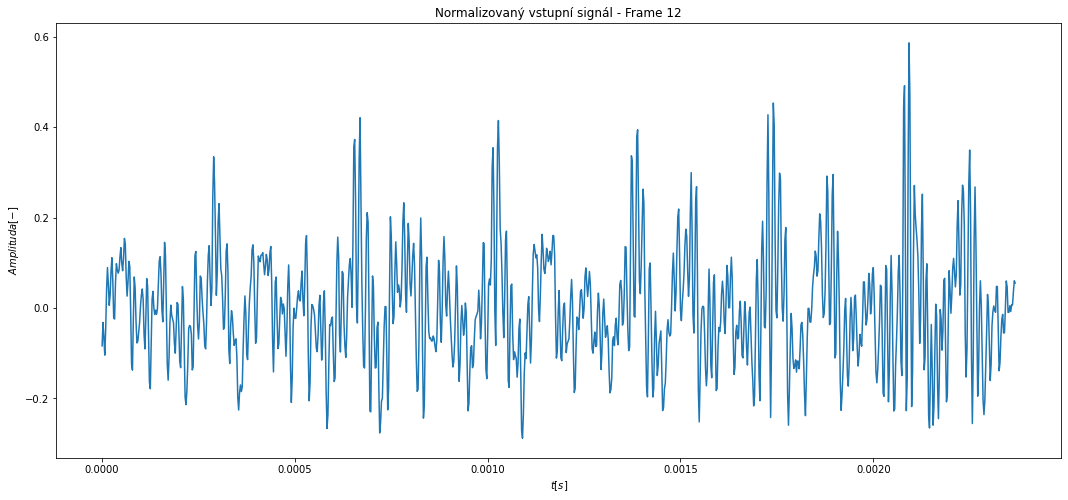

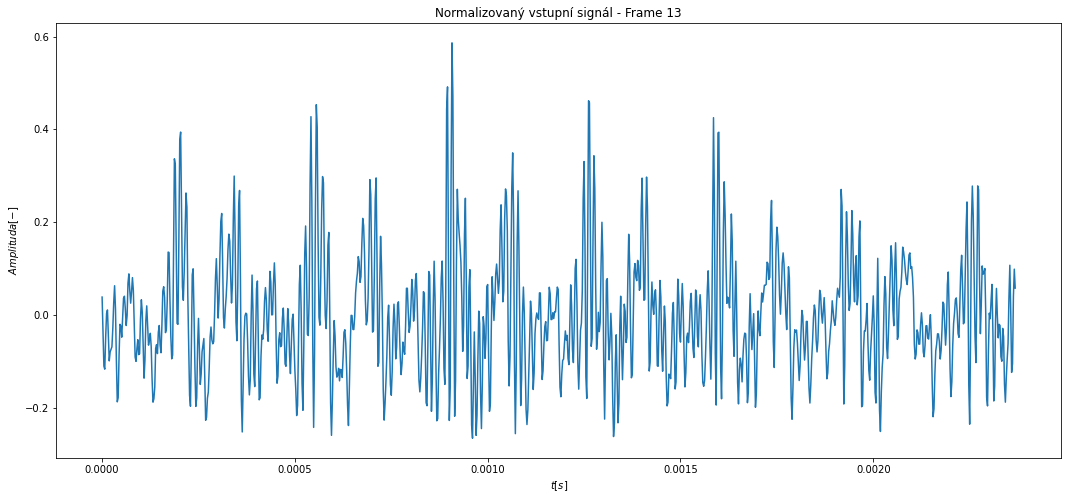

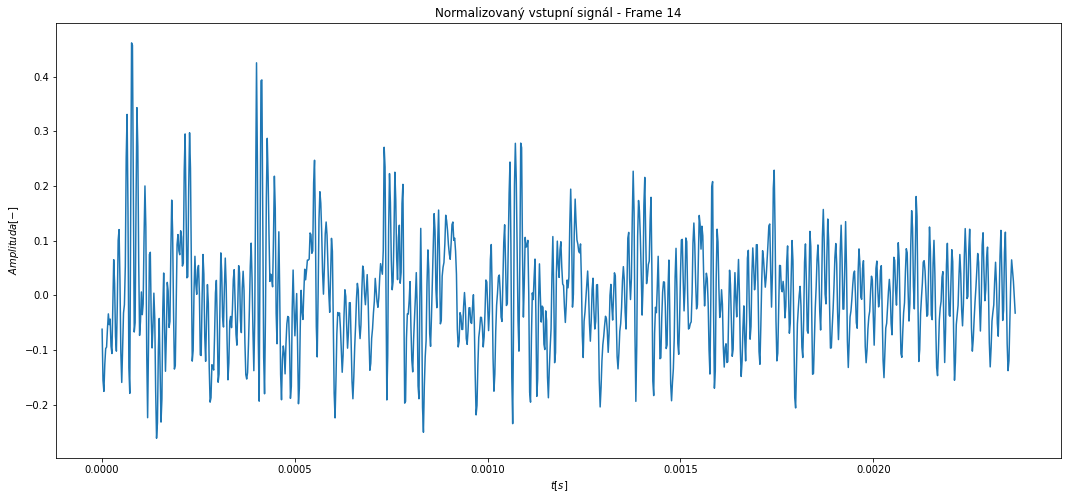

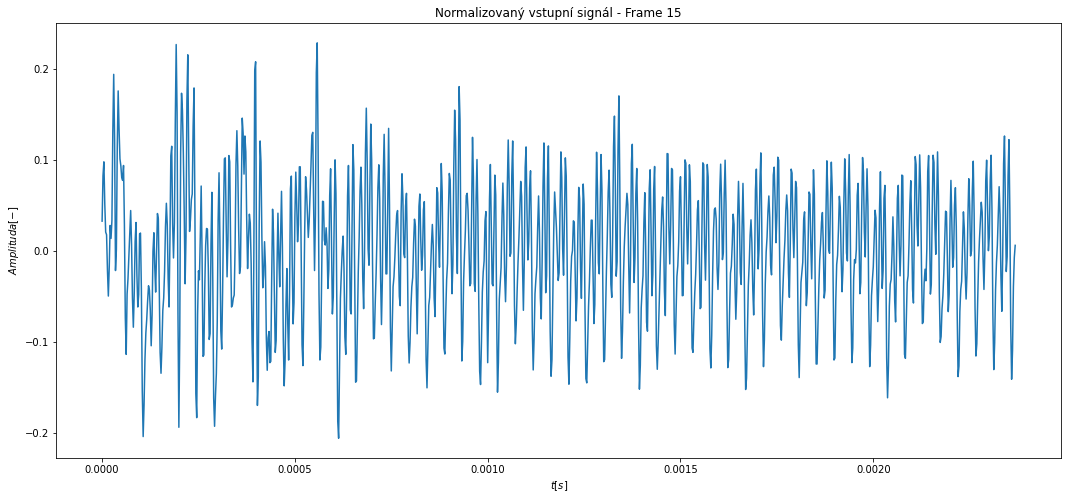

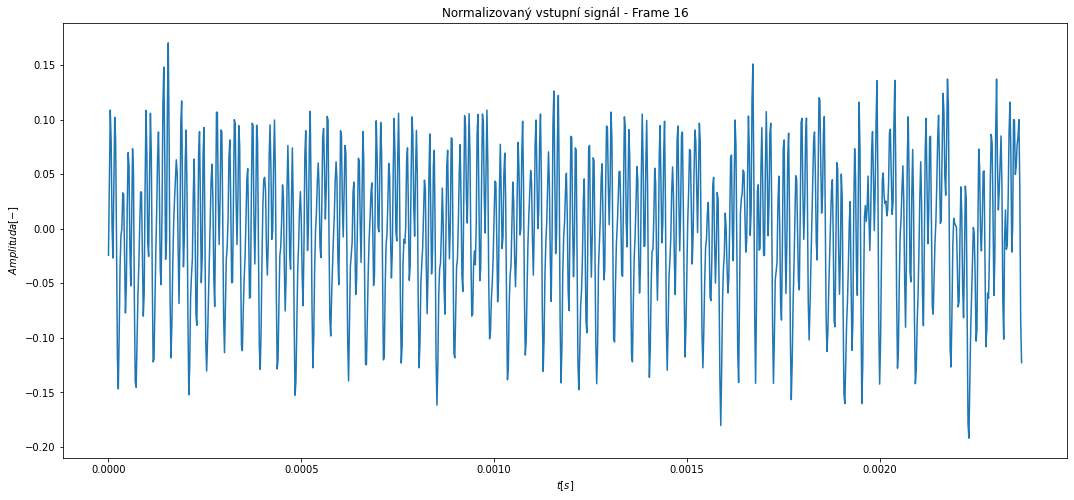

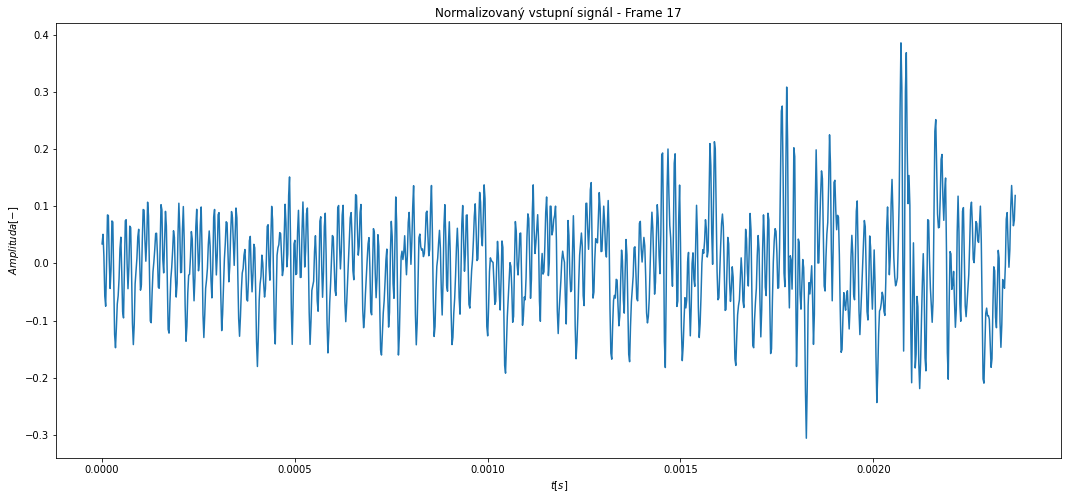

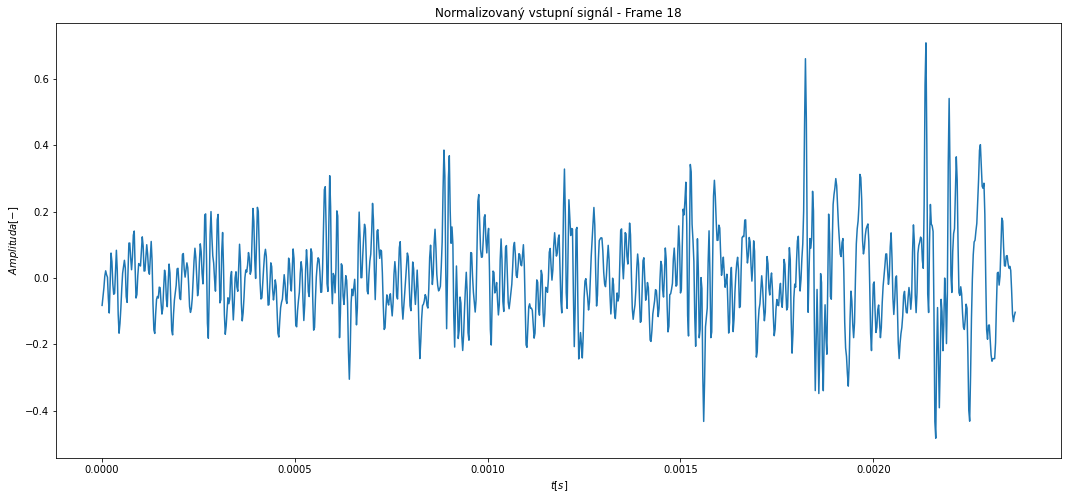

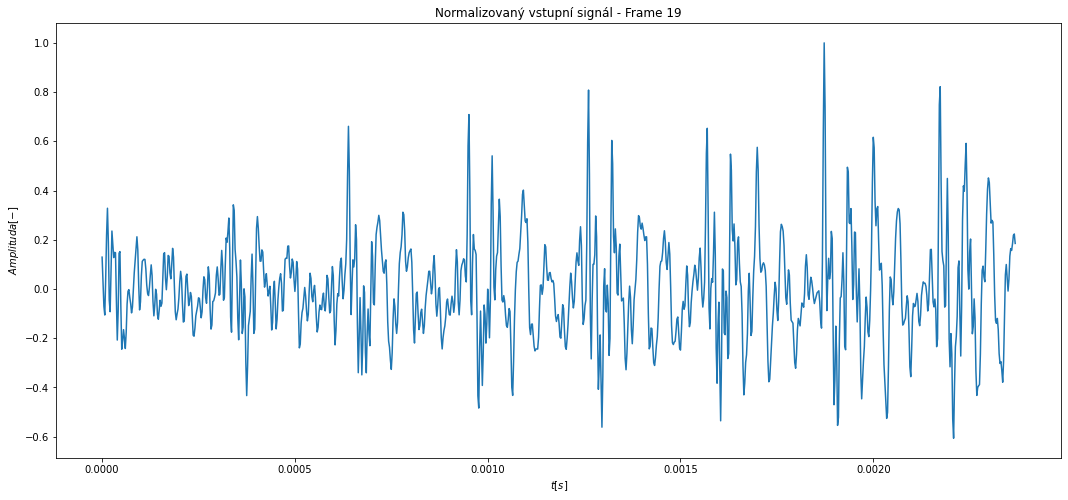

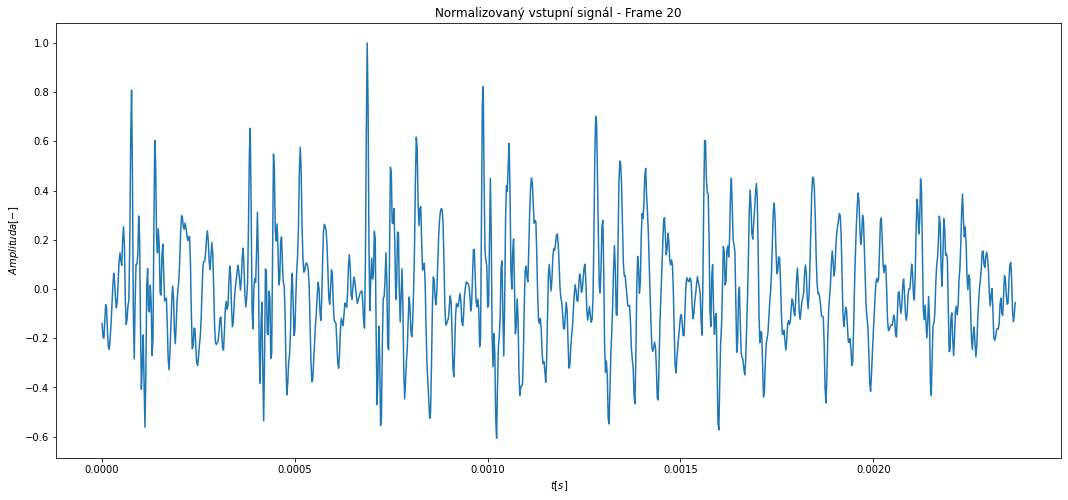

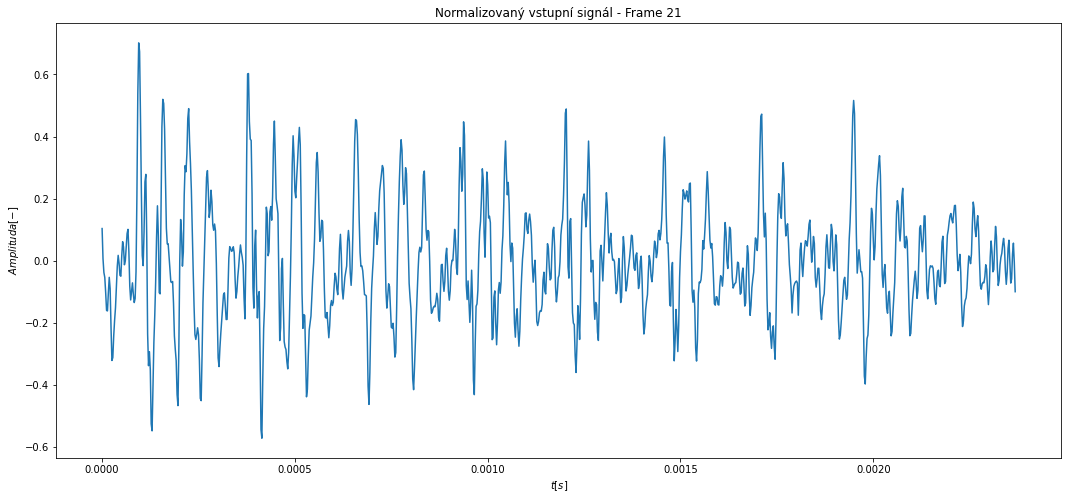

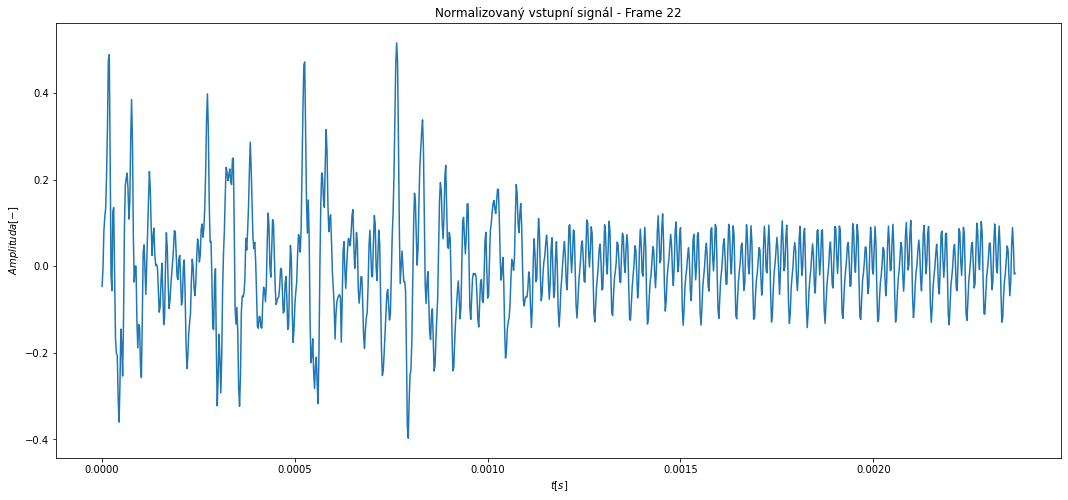

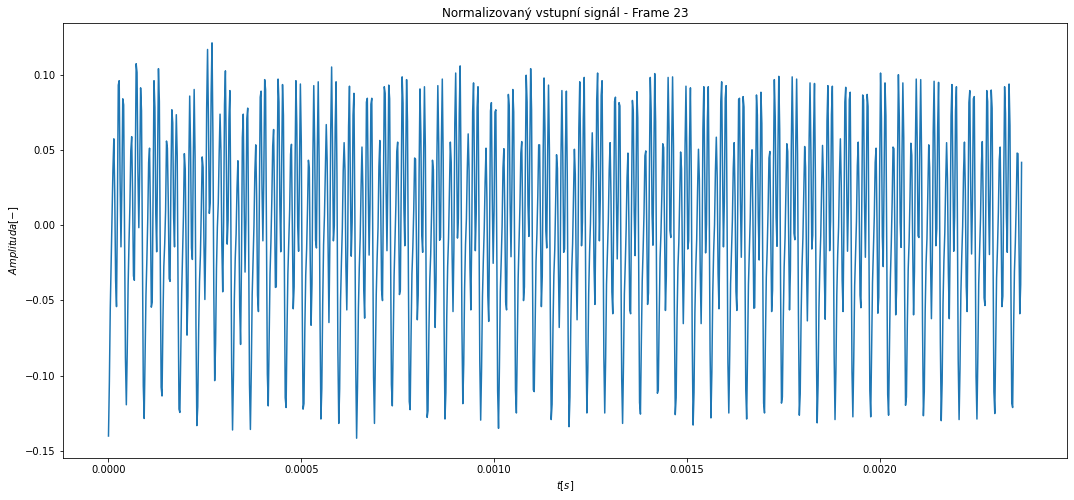

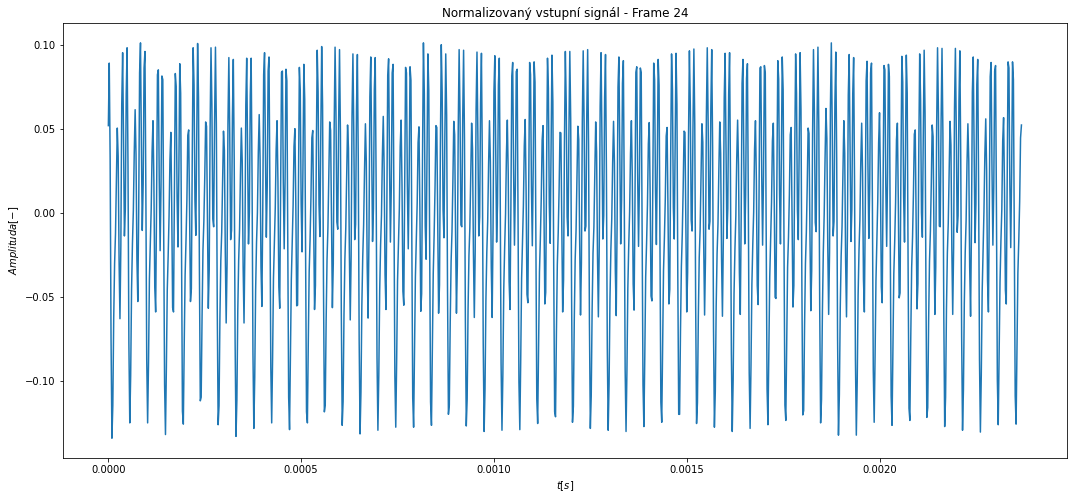

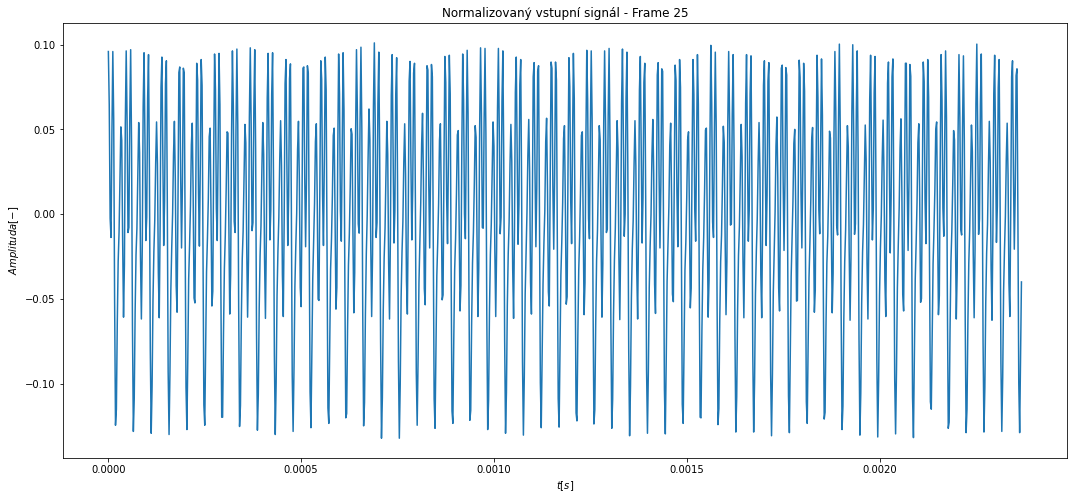

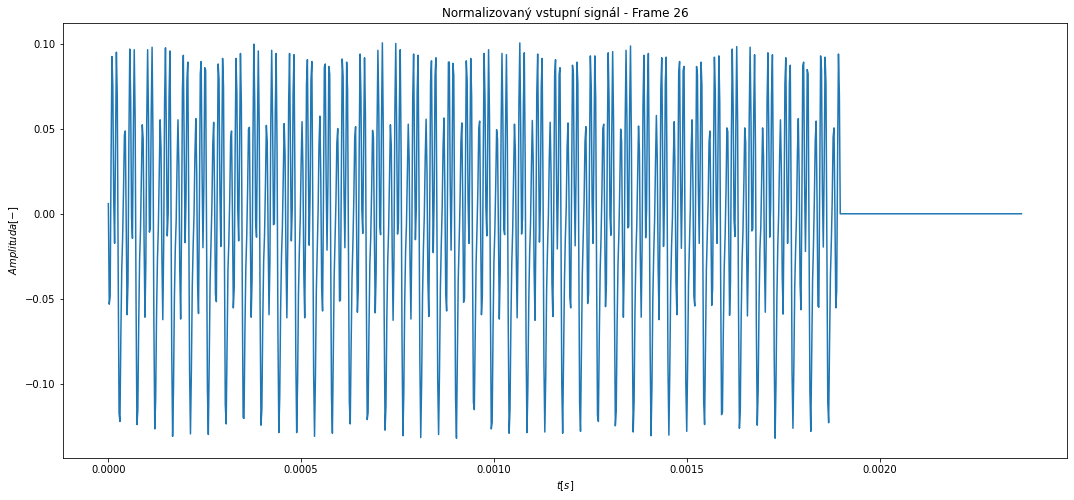

In [88]:
# Show all frames
for i in range(number_of_frames):
  plt.figure(figsize=(18,8))
  plt.title(f"Normalizovaný vstupní signál - Frame {i}")
  plt.plot(np.arange(frames[i].size) / sample_freq / number_of_frames, frames[i])
  plt.gca().set_xlabel('$t[s]$')
  plt.gca().set_ylabel('$Amplituda[-]$')
  plt.show()

# Make cols from data
frames_transformed = np.array(frames).reshape(FRAME_SIZE, number_of_frames)

Fourier transform

Are DFTs same: True


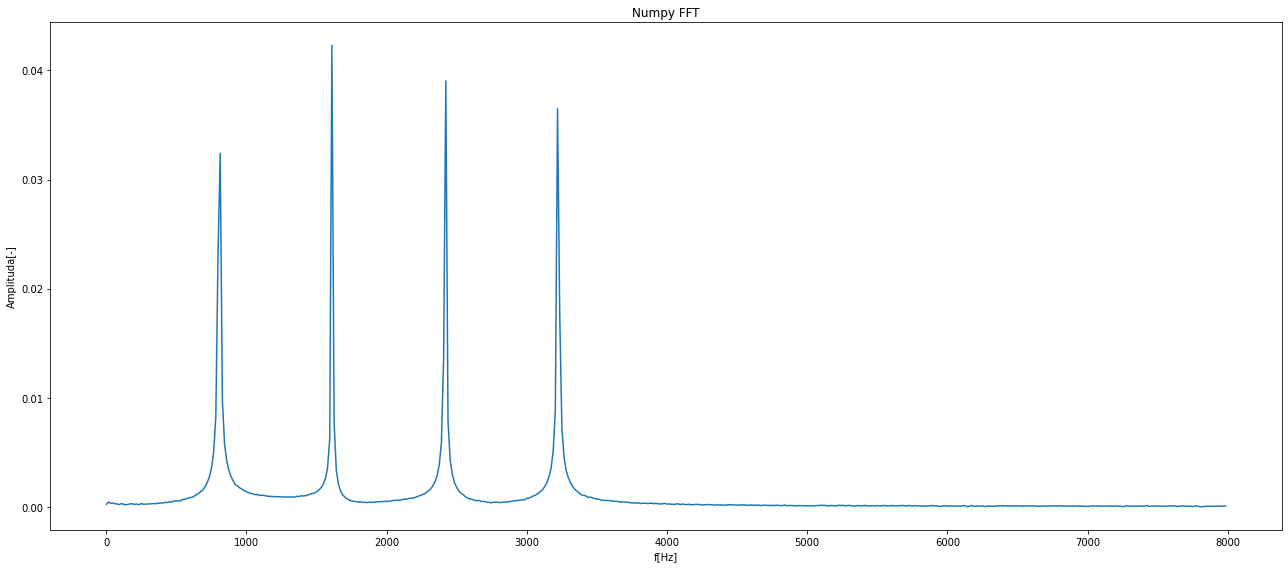

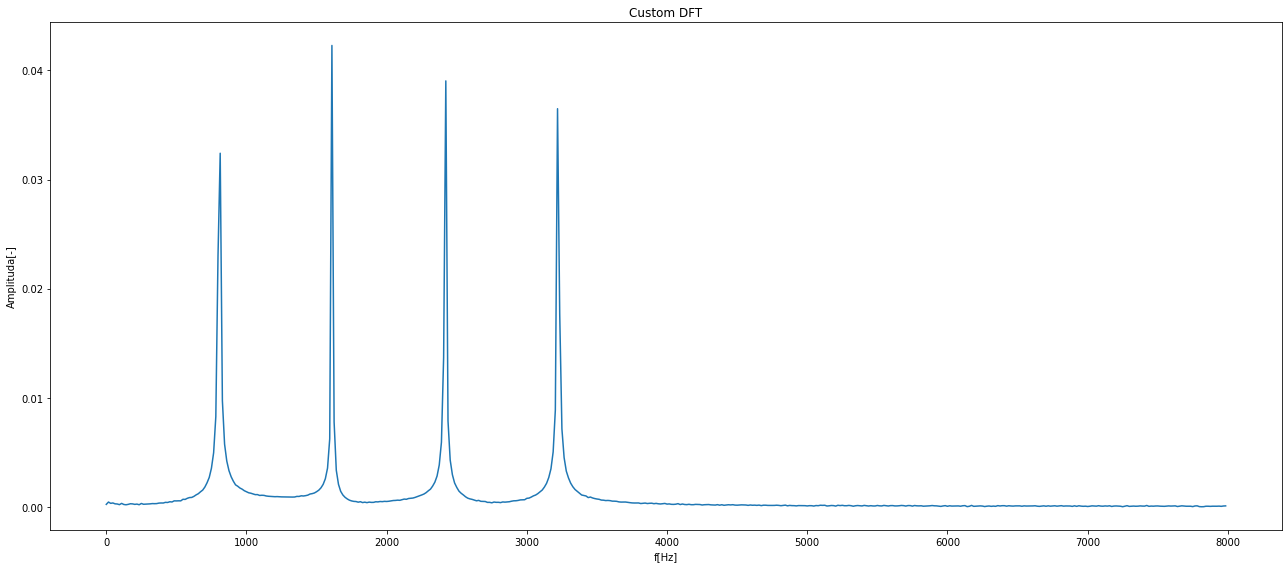

In [89]:
# Fourier transform
def dft(x):
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

buildin_fft = np.fft.fft(frames[0])
custom_dft = dft(frames[0])

data_length = len(buildin_fft)
sample_indexes = np.arange(data_length)
T = data_length/sample_freq
freq = sample_indexes/T

half_length = data_length//2
freq_one_side = freq[:half_length]

vals_buildin = buildin_fft[:half_length]/half_length
vals_custom = custom_dft[:half_length]/half_length

print(f"Are DFTs same: {np.allclose(vals_buildin, vals_custom)}")

# Plot result of custom dft and numpy fft
plt.figure(figsize=(18,8))
plt.title(f"Numpy FFT")
plt.plot(freq_one_side, abs(vals_buildin))
plt.xlabel('f[Hz]')
plt.ylabel('Amplituda[-]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(18,8))
plt.title(f"Custom DFT")
plt.plot(freq_one_side, abs(vals_buildin))
plt.xlabel('f[Hz]')
plt.ylabel('Amplituda[-]')
plt.tight_layout()
plt.show()

Spektrogram

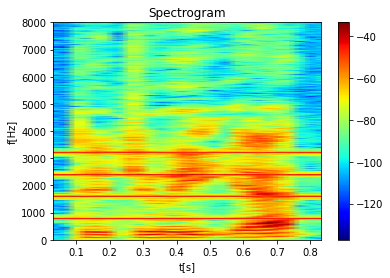

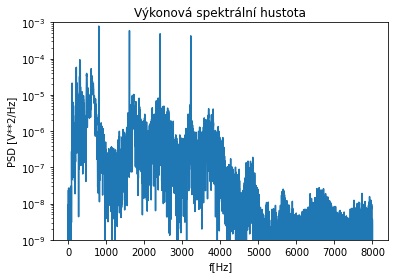

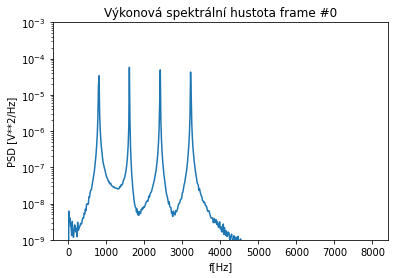

In [90]:
f, t, Sxx = signal.spectrogram(samples_normal, sample_freq, nperseg=FRAME_SIZE, noverlap=FRAME_OVERLAP)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='jet')
plt.title("Spectrogram")
plt.colorbar()
plt.ylabel('f[Hz]')
plt.xlabel('t[s]')
plt.show()

f, Pxx = signal.periodogram(samples_normal, sample_freq, scaling="density")
plt.semilogy(f, Pxx)
plt.title("Výkonová spektrální hustota")
plt.ylim([1e-9, 1e-3])
plt.xlabel('f[Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

f2, Pxx2 = signal.periodogram(frames[0], sample_freq, scaling="density")
plt.semilogy(f2, Pxx2)
plt.title("Výkonová spektrální hustota frame #0")
plt.ylim([1e-9, 1e-3])
plt.xlabel('f[Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

Get noise frequencies

In [91]:
def get_noise_frequencies(x, y, number_of_tops, band_width=100):
  signal_copy = y.copy()

  output = []

  half_width = band_width // 2

  for i in range(number_of_tops):
    idx = (-signal_copy).argsort()[0]
    output.append(x[idx])

    low_index = idx - half_width
    high_index = idx + half_width
    signal_copy[low_index : high_index] = 0
  return output

In [92]:
top_4_freqs = get_noise_frequencies(f, Pxx, 4)
print(f"Found noise frequencies: {top_4_freqs}")

top_4_freqs = [round(num, 3) for num in top_4_freqs]
print(f"Found noise frequencies rounded: {top_4_freqs}")

Found noise frequencies: [806.1137843192755, 1612.227568638551, 2418.3413529578265, 3223.3229549957546]
Found noise frequencies rounded: [806.114, 1612.228, 2418.341, 3223.323]


Generate noise

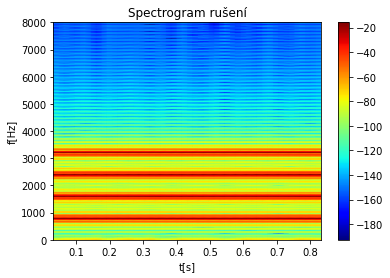

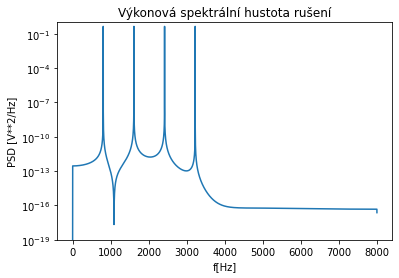

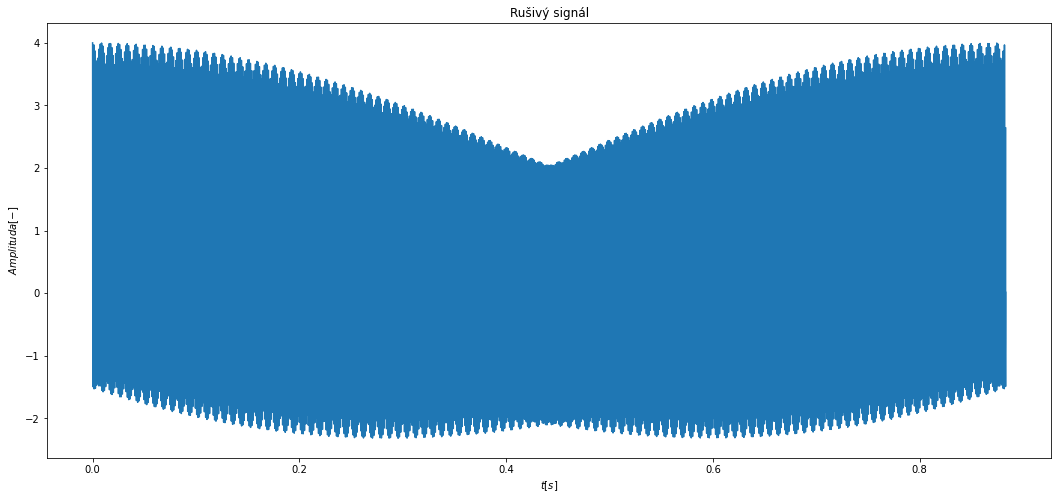

In [93]:
time = np.linspace(0, orig_length_in_secs, samples_orig.size, endpoint=False)
noise_signal = np.cos(2 * np.pi * top_4_freqs[0] * time) + \
               np.cos(2 * np.pi * top_4_freqs[1] * time) + \
               np.cos(2 * np.pi * top_4_freqs[2] * time) + \
               np.cos(2 * np.pi * top_4_freqs[3] * time)

wavfile.write("../audio/4cos.wav", sample_freq, noise_signal)

# Plot noise
f, t, Sxx = signal.spectrogram(noise_signal, sample_freq, nperseg=FRAME_SIZE, noverlap=FRAME_OVERLAP)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='jet')
plt.title("Spectrogram rušení")
plt.colorbar()
plt.ylabel('f[Hz]')
plt.xlabel('t[s]')
plt.show()

f, Pxx = signal.periodogram(noise_signal, sample_freq, scaling="density")
plt.semilogy(f, Pxx)
plt.title("Výkonová spektrální hustota rušení")
plt.xlabel('f[Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.ylim([1e-19, 1e-0])
plt.show()

plt.figure(figsize=(18,8))
plt.title("Rušivý signál")
plt.plot(np.arange(noise_signal.size) / sample_freq, noise_signal)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Amplituda[-]$')
plt.show()

Filter

In [94]:
nyq = 0.5 * sample_freq

def ellip_filter(cut_freq, output="ba"):
    block_left = cut_freq - BAND_STOP_WIDTH // 2
    block_right = cut_freq + BAND_STOP_WIDTH // 2
    open_left = block_left - BAND_DESCEND_WIDTH
    open_right = block_right + BAND_DESCEND_WIDTH

    N, Wn = signal.ellipord([open_left / nyq, open_right / nyq], [block_left / nyq, block_right / nyq], PASS_LOSS, BLOCK_ATT)
    return signal.ellip(N, PASS_LOSS, BLOCK_ATT, Wn, 'bandstop', output=output)

def butter_filter(cut_freq, output="ba"):
    block_left = cut_freq - BAND_STOP_WIDTH // 2
    block_right = cut_freq + BAND_STOP_WIDTH // 2
    open_left = block_left - BAND_DESCEND_WIDTH
    open_right = block_right + BAND_DESCEND_WIDTH

    N, Wn = signal.buttord([open_left / nyq, open_right / nyq], [block_left / nyq, block_right / nyq], PASS_LOSS, BLOCK_ATT)
    return signal.butter(N, Wn, 'bandstop', output=output)

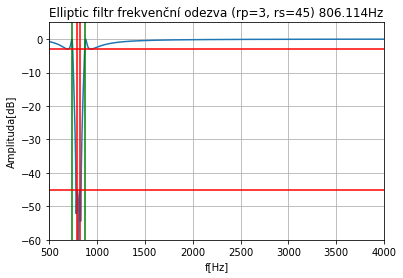

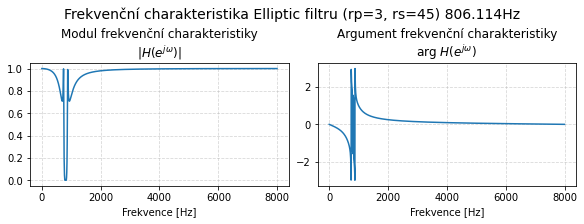

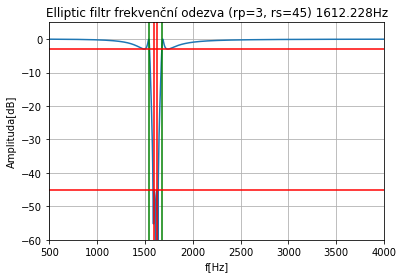

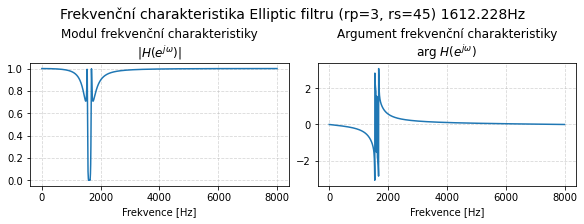

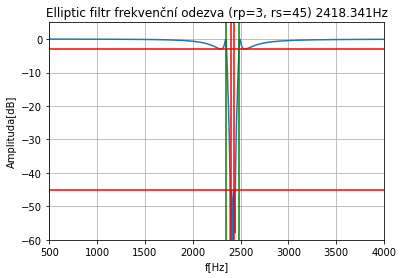

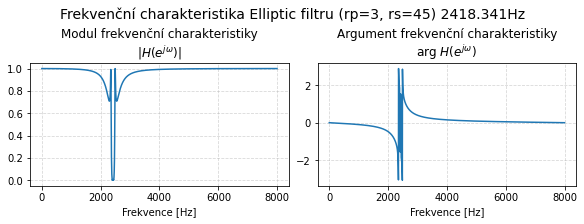

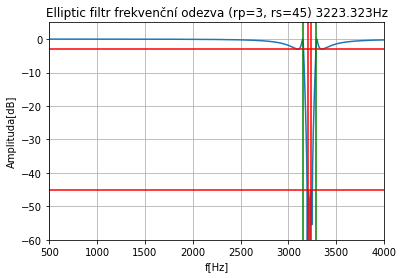

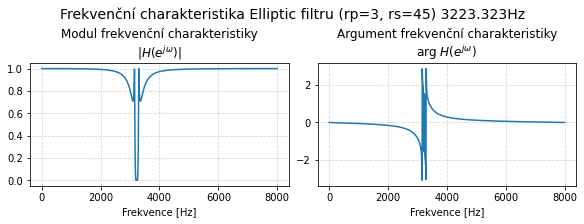

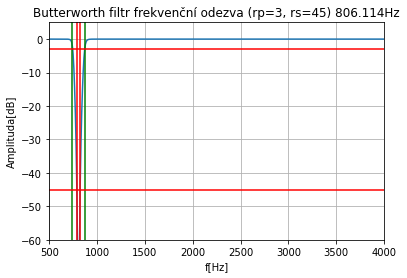

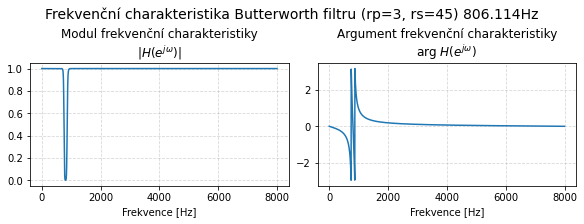

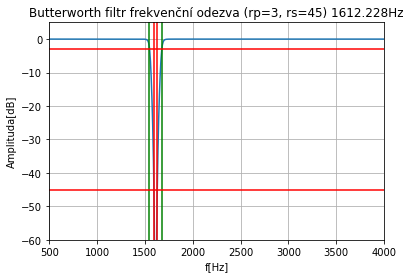

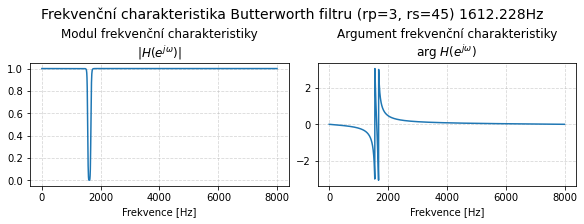

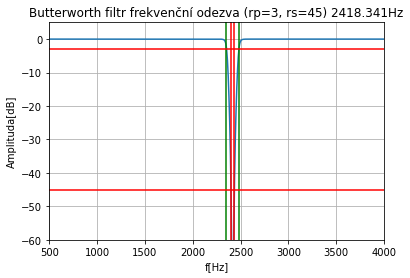

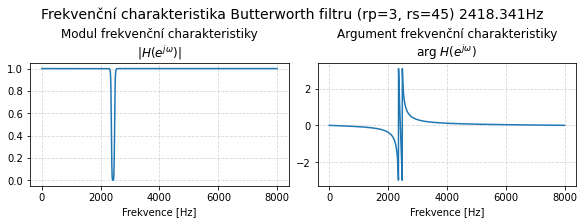

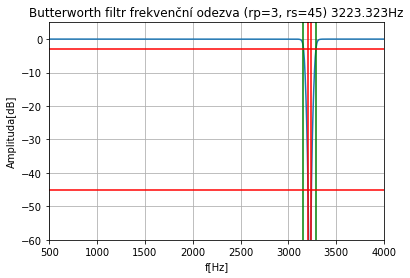

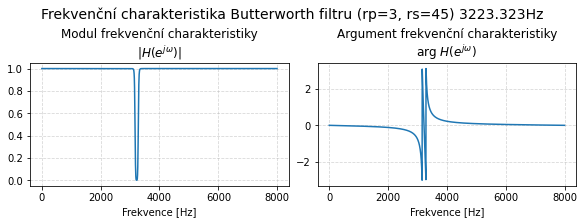

In [110]:
for i in range(4):
    sos = ellip_filter(top_4_freqs[i], "sos")
    w, h = signal.sosfreqz(sos, 2048)

    block_left = (top_4_freqs[i] - BAND_STOP_WIDTH / 2)
    block_right = (top_4_freqs[i] + BAND_STOP_WIDTH / 2)
    open_left = (block_left - BAND_DESCEND_WIDTH)
    open_right = (block_right + BAND_DESCEND_WIDTH)

    plt.plot(w / 2 / np.pi * sample_freq, 20 * np.log10(abs(h)))
    plt.title(f'Elliptic filtr frekvenční odezva (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[i]}Hz')
    plt.xlabel('f[Hz]')
    plt.ylabel('Amplituda[dB]')
    plt.axvline(open_left, color='green')
    plt.axvline(open_right, color='green')
    plt.axvline(block_left, color='red')
    plt.axvline(block_right, color='red')
    plt.axhline(-BLOCK_ATT, color='red') # rs
    plt.axhline(-PASS_LOSS, color='red') # rp
    plt.xlim([500, 4000])
    plt.ylim([-60, 5])
    plt.grid(which='both', axis='both')
    plt.show();

    fig, ax = plt.subplots(1, 2, figsize=(8,3), constrained_layout=True)
    fig.suptitle(f'Frekvenční charakteristika Elliptic filtru (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[i]}Hz', fontsize=14)

    ax[0].plot(w / 2 / np.pi * sample_freq, np.abs(h))
    ax[0].set_xlabel('Frekvence [Hz]')
    ax[0].set_title('Modul frekvenční charakteristiky\n$|H(e^{j\omega})|$')

    ax[1].plot(w / 2 / np.pi * sample_freq, np.angle(h))
    ax[1].set_xlabel('Frekvence [Hz]')
    ax[1].set_title('Argument frekvenční charakteristiky\n$\mathrm{arg}\ H(e^{j\omega})$')

    for ax1 in ax:
        ax1.grid(alpha=0.5, linestyle='--')
    plt.show()


for i in range(4):
    sos = butter_filter(top_4_freqs[i], "sos")
    w, h = signal.sosfreqz(sos, 2048)

    block_left = (top_4_freqs[i] - BAND_STOP_WIDTH / 2)
    block_right = (top_4_freqs[i] + BAND_STOP_WIDTH / 2)
    open_left = (block_left - BAND_DESCEND_WIDTH)
    open_right = (block_right + BAND_DESCEND_WIDTH)

    plt.plot(w / 2 / np.pi * sample_freq, 20 * np.log10(abs(h)))
    plt.title(f'Butterworth filtr frekvenční odezva (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[i]}Hz')
    plt.xlabel('f[Hz]')
    plt.ylabel('Amplituda[dB]')
    plt.axvline(open_left, color='green')
    plt.axvline(open_right, color='green')
    plt.axvline(block_left, color='red')
    plt.axvline(block_right, color='red')
    plt.axhline(-BLOCK_ATT, color='red') # rs
    plt.axhline(-PASS_LOSS, color='red') # rp
    plt.xlim([500, 4000])
    plt.ylim([-60, 5])
    plt.grid(which='both', axis='both')
    plt.show();

    fig, ax = plt.subplots(1, 2, figsize=(8,3), constrained_layout=True)
    fig.suptitle(f'Frekvenční charakteristika Butterworth filtru (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[i]}Hz', fontsize=14)

    ax[0].plot(w / 2 / np.pi * sample_freq, np.abs(h))
    ax[0].set_xlabel('Frekvence [Hz]')
    ax[0].set_title('Modul frekvenční charakteristiky\n$|H(e^{j\omega})|$')

    ax[1].plot(w / 2 / np.pi * sample_freq, np.angle(h))
    ax[1].set_xlabel('Frekvence [Hz]')
    ax[1].set_title('Argument frekvenční charakteristiky\n$\mathrm{arg}\ H(e^{j\omega})$')

    for ax1 in ax:
        ax1.grid(alpha=0.5, linestyle='--')
    plt.show()

Zeroes and poles

BA
[0.9503298+0.3112447j 0.9503298-0.3112447j 0.9503298+0.3112447j
 0.9503298-0.3112447j 0.9503298+0.3112447j 0.9503298-0.3112447j
 0.9503298+0.3112447j 0.9503298-0.3112447j], [0.92562631+0.31217653j 0.92562631-0.31217653j 0.93257534+0.29504668j
 0.93257534-0.29504668j 0.93332907+0.3300667j  0.93332907-0.3300667j
 0.94862091+0.28762979j 0.94862091-0.28762979j]
[0.80620254+0.59163964j 0.80620254-0.59163964j 0.80620254+0.59163964j
 0.80620254-0.59163964j 0.80620254+0.59163964j 0.80620254-0.59163964j
 0.80620254+0.59163964j 0.80620254-0.59163964j], [0.78206389+0.58520319j 0.78206389-0.58520319j 0.79365133+0.5704078j
 0.79365133-0.5704078j  0.78427262+0.60440026j 0.78427262-0.60440026j
 0.81194636+0.56772929j 0.81194636-0.56772929j]
[0.58195843+0.81321853j 0.58195843-0.81321853j 0.58195843+0.81321853j
 0.58195843-0.81321853j 0.58195843+0.81321853j 0.58195843-0.81321853j
 0.58195843+0.81321853j 0.58195843-0.81321853j], [0.5608325 +0.7996808j  0.5608325 -0.7996808j  0.5764031 +0.78892358j
 0

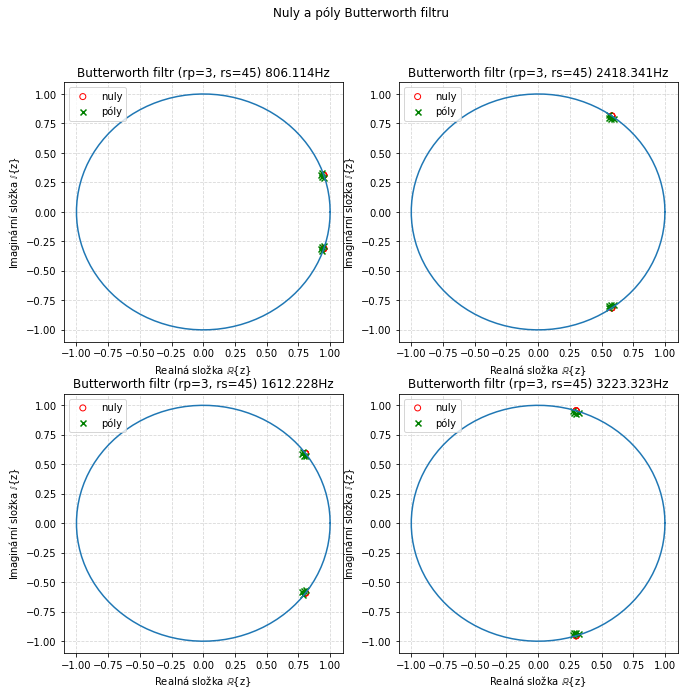

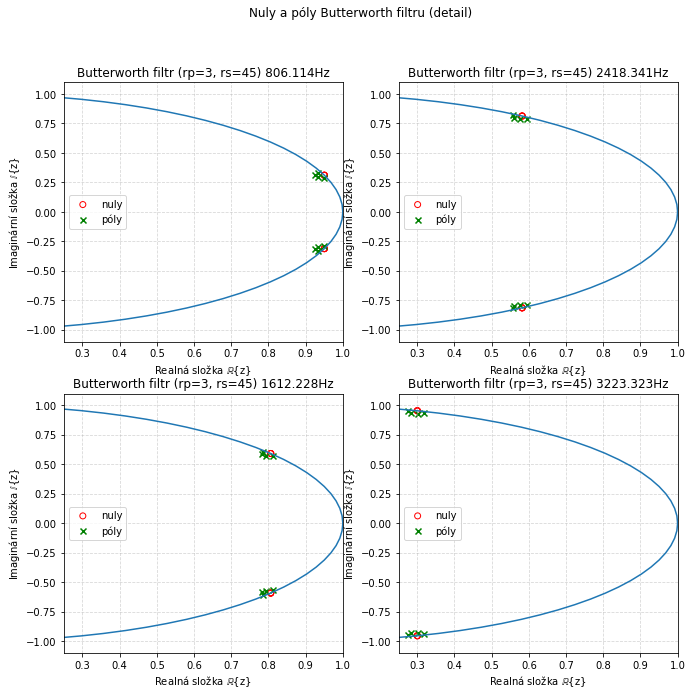


EL
[0.95033007+0.31124387j 0.95033007-0.31124387j 0.94738108+0.32010793j
 0.94738108-0.32010793j 0.95311777+0.30259959j 0.95311777-0.30259959j], [0.88138766+0.27939985j 0.88138766-0.27939985j 0.93740121+0.3356885j
 0.93740121-0.3356885j  0.95438903+0.28604216j 0.95438903-0.28604216j]
[0.80620275+0.59163935j 0.80620275-0.59163935j 0.80057768+0.59922899j
 0.80057768-0.59922899j 0.81168575+0.58409437j 0.81168575-0.58409437j], [0.74668898+0.54296948j 0.74668898-0.54296948j 0.78641497+0.61085952j
 0.78641497-0.61085952j 0.81830258+0.56795153j 0.81830258-0.56795153j]
[0.58195785+0.81321895j 0.58195785-0.81321895j 0.57421481+0.81870468j
 0.57421481-0.81870468j 0.58959679+0.80769773j 0.58959679-0.80769773j], [0.53869922+0.74909099j 0.53869922-0.74909099j 0.55721005+0.82534355j
 0.55721005-0.82534355j 0.60110839+0.79414007j 0.60110839-0.79414007j]
[0.300301  +0.95384449j 0.300301  -0.95384449j 0.29120982+0.95665921j
 0.29120982-0.95665921j 0.30933795+0.95095217j 0.30933795-0.95095217j], [0.277

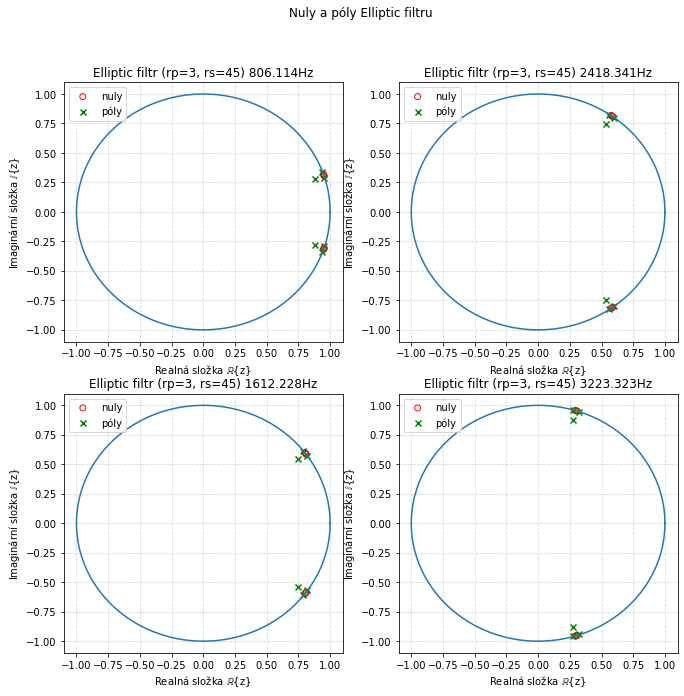

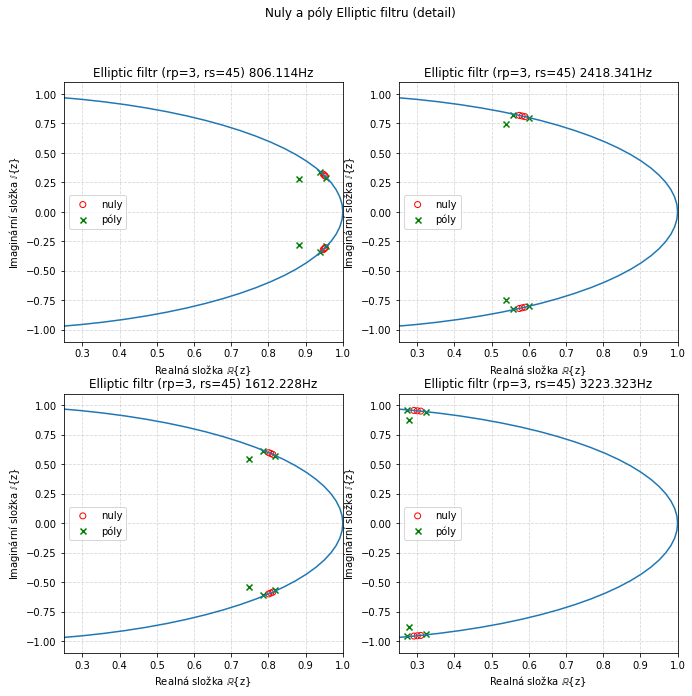

In [96]:
print("BA")
fig, axs = plt.subplots(2, 2, figsize=(11,10.5))
fig.suptitle("Nuly a póly Butterworth filtru")
i = j = k = 0

for l in range(4):
    sos = butter_filter(top_4_freqs[l], "sos")
    z, p, _ = signal.sos2zpk(sos)

    print(f"{z}, {p}")

    # jednotkova kruznice
    ang = np.linspace(0, 2*np.pi,100)
    axs[i, j].plot(np.cos(ang), np.sin(ang))

    # nuly, poly
    axs[i, j].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
    axs[i, j].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

    axs[i, j].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
    axs[i, j].set_ylabel('Imaginární složka $\mathbb{I}\{$z$\}$')

    axs[i, j].grid(alpha=0.5, linestyle='--')
    axs[i, j].legend(loc='upper left')

    axs[i, j].set_title(f"Butterworth filtr (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[int(k)]}Hz")

    k += 1
    i += 1
    if i > 1:
        i = 0
        j += 1

plt.show()

fig, axs = plt.subplots(2, 2, figsize=(11,10.5))
fig.suptitle("Nuly a póly Butterworth filtru (detail)")
i = j = k = 0

for l in range(4):
    sos = butter_filter(top_4_freqs[l], "sos")
    z, p, _ = signal.sos2zpk(sos)

    # jednotkova kruznice
    ang = np.linspace(0, 2*np.pi,100)
    axs[i, j].plot(np.cos(ang), np.sin(ang))

    # nuly, poly
    axs[i, j].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
    axs[i, j].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

    axs[i, j].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
    axs[i, j].set_ylabel('Imaginární složka $\mathbb{I}\{$z$\}$')

    axs[i, j].grid(alpha=0.5, linestyle='--')
    axs[i, j].legend(loc='center left')

    axs[i, j].set_title(f"Butterworth filtr (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[int(k)]}Hz")
    axs[i, j].set_xlim([0.25, 1.0])

    k += 1
    i += 1
    if i > 1:
        i = 0
        j += 1

plt.show()

print("\nEL")
fig, axs = plt.subplots(2, 2, figsize=(11,10.5))
fig.suptitle("Nuly a póly Elliptic filtru")
i = j = k = 0

for l in range(4):
    sos = ellip_filter(top_4_freqs[l], "sos")
    z, p, _ = signal.sos2zpk(sos)

    print(f"{z}, {p}")

    # jednotkova kruznice
    ang = np.linspace(0, 2*np.pi,100)
    axs[i, j].plot(np.cos(ang), np.sin(ang))

    # nuly, poly
    axs[i, j].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
    axs[i, j].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

    axs[i, j].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
    axs[i, j].set_ylabel('Imaginární složka $\mathbb{I}\{$z$\}$')

    axs[i, j].grid(alpha=0.5, linestyle='--')
    axs[i, j].legend(loc='upper left')

    axs[i, j].set_title(f"Elliptic filtr (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[int(k)]}Hz")

    k += 1
    i += 1
    if i > 1:
        i = 0
        j += 1

plt.show()

fig, axs = plt.subplots(2, 2, figsize=(11,10.5))
fig.suptitle("Nuly a póly Elliptic filtru (detail)")
i = j = k = 0

for l in range(4):
    sos = ellip_filter(top_4_freqs[l], "sos")
    z, p, _ = signal.sos2zpk(sos)

    # jednotkova kruznice
    ang = np.linspace(0, 2*np.pi,100)
    axs[i, j].plot(np.cos(ang), np.sin(ang))

    # nuly, poly
    axs[i, j].scatter(np.real(z), np.imag(z), marker='o', facecolors='none', edgecolors='r', label='nuly')
    axs[i, j].scatter(np.real(p), np.imag(p), marker='x', color='g', label='póly')

    axs[i, j].set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
    axs[i, j].set_ylabel('Imaginární složka $\mathbb{I}\{$z$\}$')

    axs[i, j].grid(alpha=0.5, linestyle='--')
    axs[i, j].legend(loc='center left')

    axs[i, j].set_title(f"Elliptic filtr (rp={PASS_LOSS}, rs={BLOCK_ATT}) {top_4_freqs[int(k)]}Hz")
    axs[i, j].set_xlim([0.25, 1.0])

    k += 1
    i += 1
    if i > 1:
        i = 0
        j += 1

plt.show()

Dirac impulse

In [97]:
sos_el = [ellip_filter(top_4_freqs[0], "sos"), ellip_filter(top_4_freqs[1], "sos"), ellip_filter(top_4_freqs[2], "sos"), ellip_filter(top_4_freqs[3], "sos")]
sos_bt = [butter_filter(top_4_freqs[0], "sos"), butter_filter(top_4_freqs[1], "sos"), butter_filter(top_4_freqs[2], "sos"), butter_filter(top_4_freqs[3], "sos")]

In [98]:
dirac_impulse = np.zeros_like(samples_normal.copy())
dirac_impulse[0] = 1

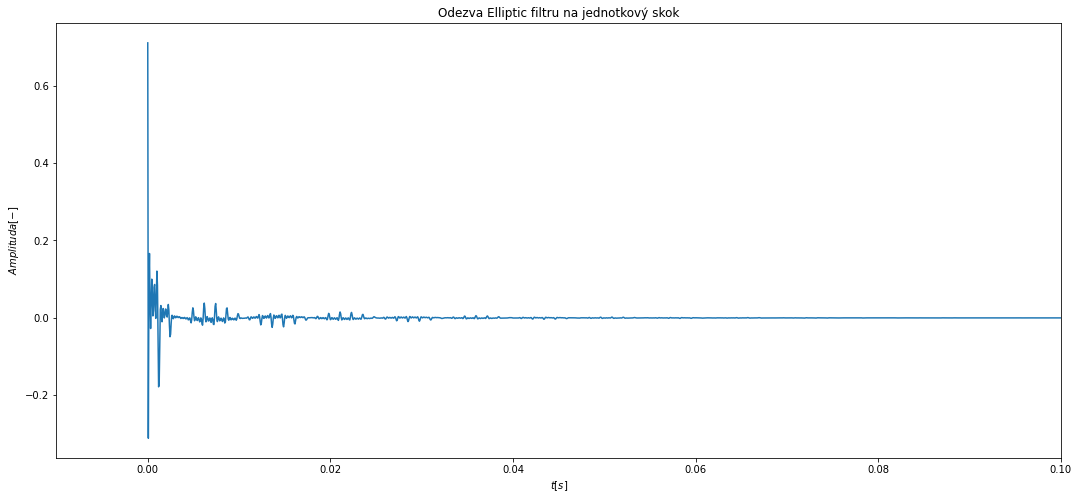

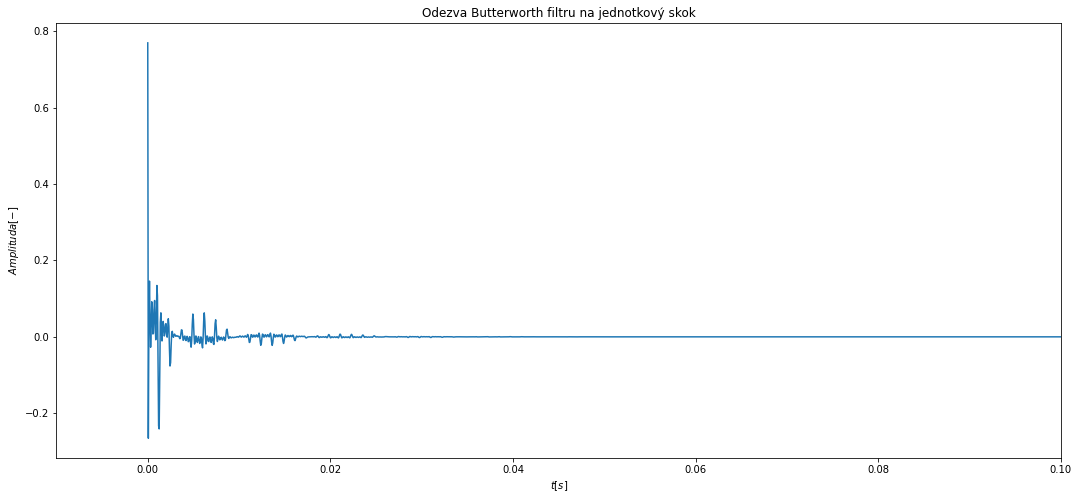

In [99]:
data = dirac_impulse
for sos in sos_el:
    data = signal.sosfilt(sos, data)

plt.figure(figsize=(18,8))
plt.title("Odezva Elliptic filtru na jednotkový skok")
plt.plot(np.arange(data.size) / sample_freq, data)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Amplituda[-]$')
plt.xlim([-0.01, 0.1])
plt.show()

data = dirac_impulse
for sos in sos_bt:
    data = signal.sosfilt(sos, data)

plt.figure(figsize=(18,8))
plt.title("Odezva Butterworth filtru na jednotkový skok")
plt.plot(np.arange(data.size) / sample_freq, data)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Amplituda[-]$')
plt.xlim([-0.01, 0.1])
plt.show()

Filter signal

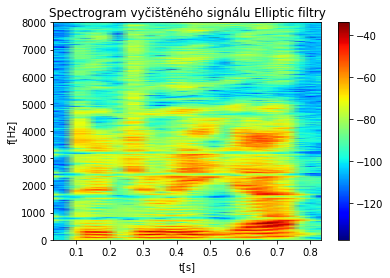

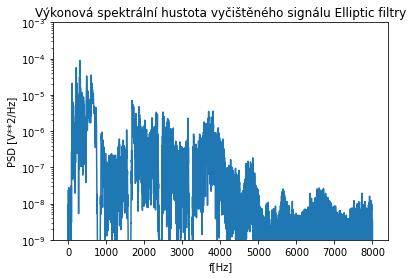

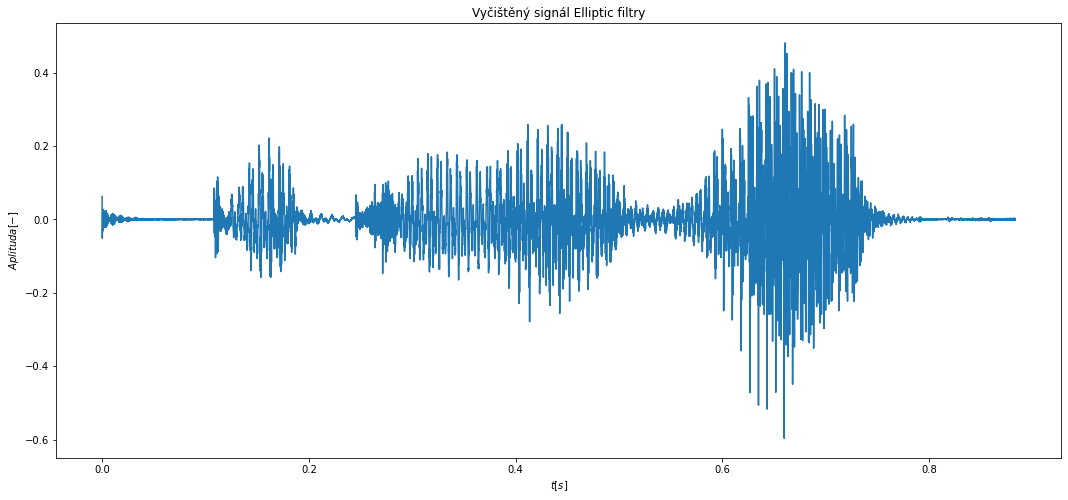

Output before
Stats:
Max: 0.48089889599109903, Min: -0.5959723493869783, Avg: -4.399549101313023e-06, Mean: -4.399549101313023e-06, Med: -3.070150988221951e-05
Output after
Stats:
Max: 0.8069281169751192, Min: -1.0, Avg: -1.1360952343307741e-05, Mean: -1.6654916587923379e-18, Med: -4.413317996053563e-05


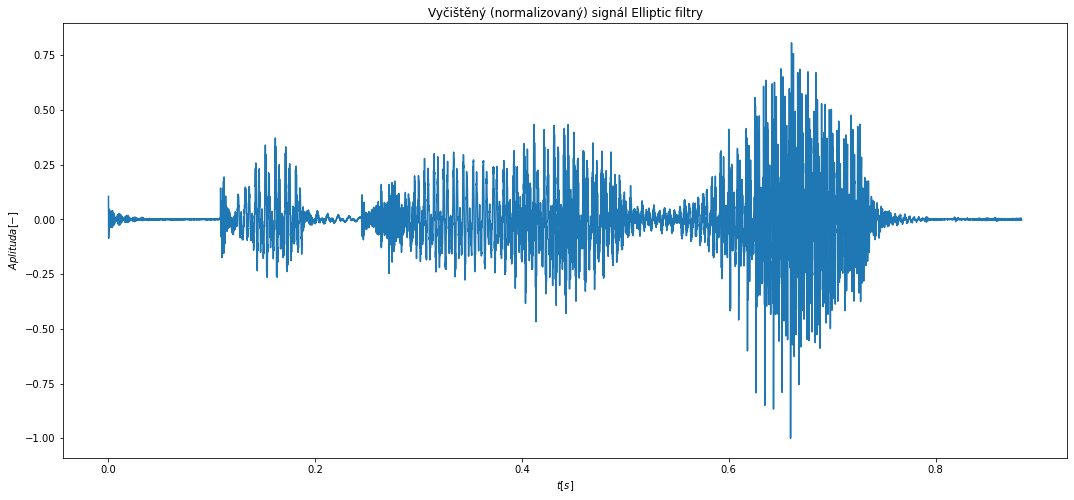

In [100]:
data = samples_normal

for sos in sos_el:
    data = signal.sosfilt(sos, data)

# Spectrogram of cleared signal
f, t, Sxx = signal.spectrogram(data, sample_freq, nperseg=FRAME_SIZE, noverlap=FRAME_OVERLAP)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='jet')
plt.title("Spectrogram vyčištěného signálu Elliptic filtry")
plt.colorbar()
plt.ylabel('f[Hz]')
plt.xlabel('t[s]')
plt.show()

f, Pxx = signal.periodogram(data, sample_freq, scaling="density")
plt.semilogy(f, Pxx)
plt.title("Výkonová spektrální hustota vyčištěného signálu Elliptic filtry")
plt.ylim([1e-9, 1e-3])
plt.xlabel('f[Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

plt.figure(figsize=(18,8))
plt.title("Vyčištěný signál Elliptic filtry")
plt.plot(np.arange(data.size) / sample_freq, data)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Aplituda[-]$')
plt.show()

print("Output before")
print(f"Stats:\nMax: {max(data)}, Min: {min(data)}, Avg: {average(data)}, Mean: {np.mean(data)}, Med: {median(data)}")

data = normalization(data)

print("Output after")
print(f"Stats:\nMax: {max(data)}, Min: {min(data)}, Avg: {average(samples_orig)}, Mean: {np.mean(data)}, Med: {median(data)}")

plt.figure(figsize=(18,8))
plt.title("Vyčištěný (normalizovaný) signál Elliptic filtry")
plt.plot(np.arange(data.size) / sample_freq, data)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Aplituda[-]$')
plt.show()

# Save filtered input signal
wavfile.write("../audio/clean_bandstop.wav", sample_freq, data)

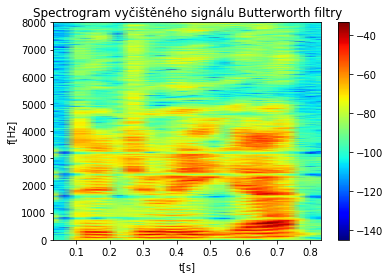

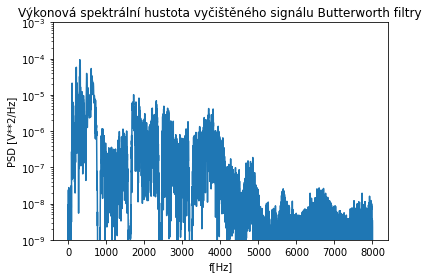

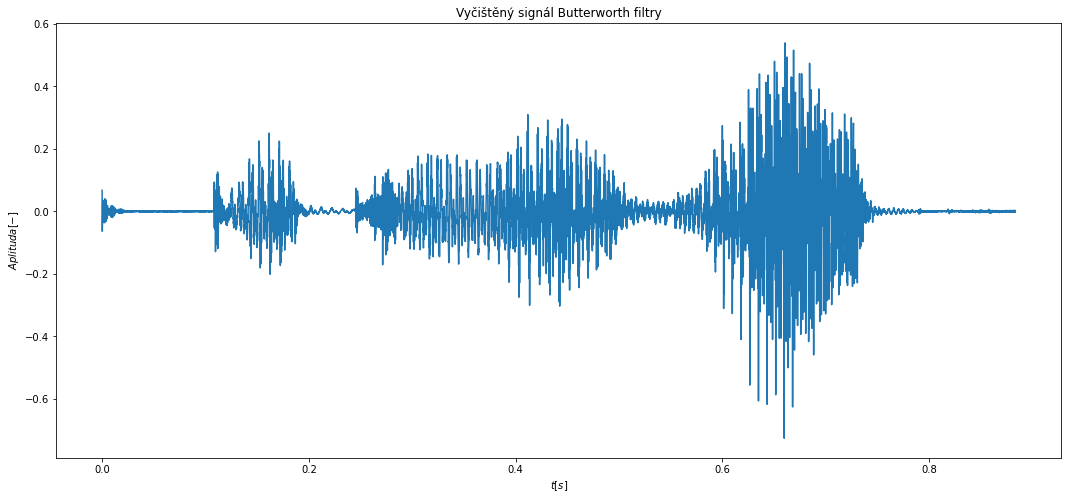

In [101]:
data = samples_normal

for sos in sos_bt:
    data = signal.sosfilt(sos, data)

# Spectrogram of cleared signal
f, t, Sxx = signal.spectrogram(data, sample_freq, nperseg=FRAME_SIZE, noverlap=FRAME_OVERLAP)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap='jet')
plt.title("Spectrogram vyčištěného signálu Butterworth filtry")
plt.colorbar()
plt.ylabel('f[Hz]')
plt.xlabel('t[s]')
plt.show()

f, Pxx = signal.periodogram(data, sample_freq, scaling="density")
plt.semilogy(f, Pxx)
plt.title("Výkonová spektrální hustota vyčištěného signálu Butterworth filtry")
plt.ylim([1e-9, 1e-3])
plt.xlabel('f[Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

plt.figure(figsize=(18,8))
plt.title("Vyčištěný signál Butterworth filtry")
plt.plot(np.arange(data.size) / sample_freq, data)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_ylabel('$Aplituda[-]$')
plt.show()

# wavfile.write("audio/clean_bandstop.wav", sample_freq, data)